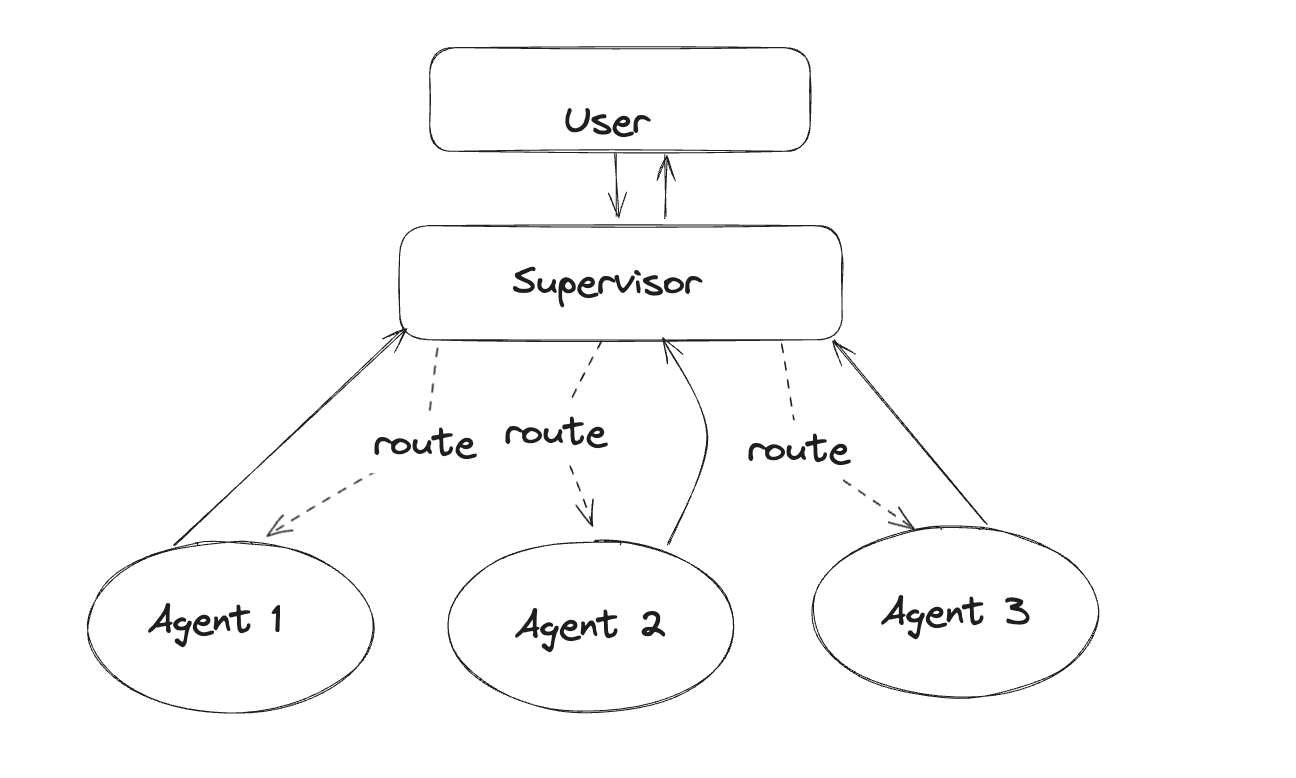

tools 정의

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

supervisor 정의

In [ ]:
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from enum import Enum
from pydantic import BaseModel
from typing import Literal

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

members = ["Researcher", "Coder"] #각 tool agent
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
class routeResponse(BaseModel):
    next: Literal["FINISH", "Researcher", "Coder"]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


llm = ChatOpenAI(model="gpt-4o")

def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

tool , supervisor 노드 init

In [ ]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)

각 노드 연결

In [ ]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")